### Imports go here

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

## Lets see the data

In [2]:
df = pd.read_csv('data/pulsar_stars.csv')
print(df.shape)
df.head()

(17898, 9)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## **Step 1**: Distinguish the problem:

This will be a classification problem. We know that because the target values are either 0 or 1.

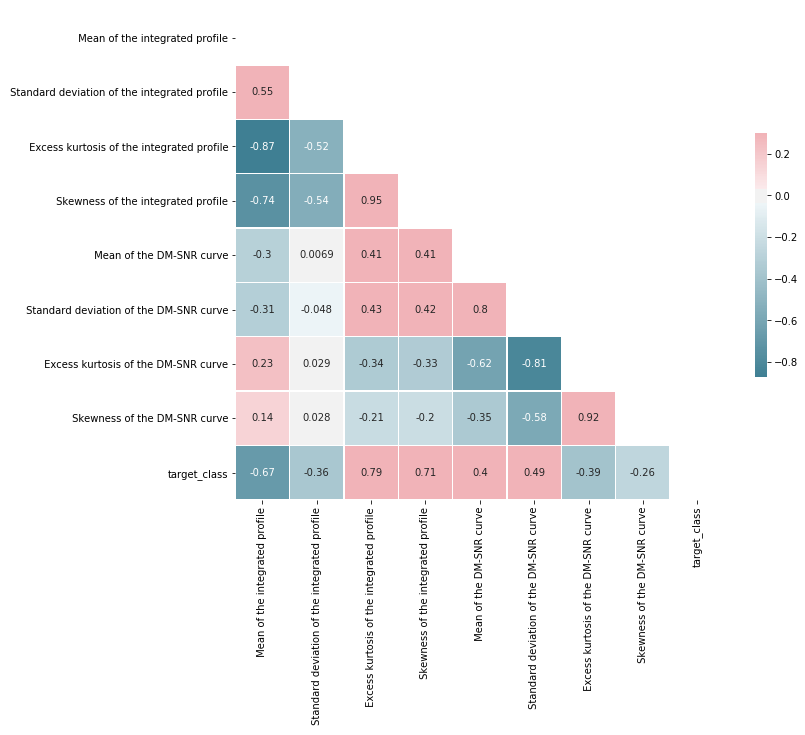

In [3]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()


## **Step 2**: Split the data:

In [4]:
X = np.asarray(df.drop('target_class', axis=1))
y = df['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [5]:
# scale the data
standard_scaler = preprocessing.StandardScaler()
X_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

## **Step 3 (SVC):** Instantiate the appropriate ML model:
We are going to start with using an SVM model and then use a logistic regression model and compare their results.

In [6]:
# Instantiate an SVC object
clf = SVC(gamma='auto')

## **Step 4 (SVC):** Train the model:

In [7]:
# fit the data to the model
clf.fit(X_standard, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## **Step 5 (SVC):** Predict based on X_test:

In [8]:
# predict y values from x_test
y_pred = clf.predict(X_test_standard)

## **Step 6 (SVC):** Evaluate the model:

In [9]:
# create a confusion matrix to evaluate the model
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[4093,   22],
       [  63,  297]])

In [10]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('f1 score:', f1)

Accuracy: 0.9810055865921787
Precision: 0.9310344827586207
Recall: 0.825
f1 score: 0.8748159057437407


In [27]:
from sklearn.model_selection import cross_val_score

all_accuracies = cross_val_score(estimator=clf, X=X, y=y, cv=5, scoring='accuracy')
print(all_accuracies)
print(all_accuracies.mean())

[0.97458101 0.97960894 0.98072626 0.97765363 0.97792063]
0.9780980916900612


## **Step 7 (SVC):** Make the model better:

In [12]:
def SVM_model_accuracy(X, target):
    # Break up the data into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, random_state=0)
    # scale the data (standard)
    standard_scaler = preprocessing.StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_test_scaled = standard_scaler.transform(X_test)
    # create an SVC object
    clf = SVC(gamma='auto')
    # fit the data to our SVC oject
    clf.fit(X_train_scaled, y_train)
    # using our model predict the x_tests y vals
    y_pred = clf.predict(X_test_scaled)
    # predict the model's accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    # compare the y_pred to the y_test in a confusion matrix
    # confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    return accuracy

In [13]:
def find_best_features(df, target):
    columns = set(df.columns)
    X = df[columns]
    best_model = SVM_model_accuracy(X, target), columns
    for column in df.columns:
        current_model = SVM_model_accuracy(df[ columns - {column}], target), columns - {column}
        if current_model > best_model:
            best_model = current_model
            columns -= {column}
    return best_model

In [14]:
find_best_features(df.drop('target_class', axis=1), df['target_class'])

(0.9823463687150839,
 {' Excess kurtosis of the integrated profile',
  ' Mean of the DM-SNR curve',
  ' Skewness of the DM-SNR curve',
  ' Skewness of the integrated profile',
  ' Standard deviation of the DM-SNR curve'})

## Final Evaluation:
- This was the best model I could come up with for an SVC model.
- I also tried using min max scaling, but the acccuracy was slightly worse.

# Logistic Regression

## **Step 3 (LogReg):** Instantiate the appropriate ML model: 

In [15]:
# instantiate the logreg model
logreg = LogisticRegression()

## **Step 4 (LogReg):** Train the model:

In [16]:
# fit model
logreg.fit(X_standard, y_train)
X_standard

array([[ 0.89035   ,  0.05299446, -0.41627838, ..., -0.35147554,
         0.06520135, -0.22396846],
       [-3.24056646, -1.87170607,  3.9915008 , ...,  2.67629293,
        -1.9123934 , -0.99480636],
       [-0.12169131,  0.80272308, -0.19304623, ...,  0.71942064,
        -1.09329823, -0.88784571],
       ...,
       [ 0.8619609 ,  1.30140731, -0.54015109, ..., -0.70446375,
         0.86343194,  0.7259099 ],
       [-0.49074965,  0.32702693, -0.16241881, ..., -0.52302369,
         0.42620276,  0.17217532],
       [-0.18632182, -0.65621566, -0.06075285, ..., -0.33290731,
        -0.21425354, -0.43159673]])

## **Step 5 (LogReg):** Predict based on X_test:

In [17]:
y_pred = logreg.predict(X_test_standard)

## **Step 6 (LogReg):** Evaluate the model:

In [18]:
# create a confusion matrix to evaluate the model
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[4095,   20],
       [  64,  296]])

In [19]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('f1 score:', f1)

Accuracy: 0.9812290502793296
Precision: 0.9367088607594937
Recall: 0.8222222222222222
f1 score: 0.8757396449704142


In [20]:
from sklearn.model_selection import cross_val_score

all_accuracies = cross_val_score(estimator=logreg, X=X, y=y, cv=5, scoring='accuracy')
print(all_accuracies)
print(all_accuracies.mean())

[0.97458101 0.97960894 0.98072626 0.97765363 0.97792063]
0.9780980916900612


#### The Logistic Regression model has the same scores as the SVM model!

## **Step 7 (LogReg):** Make the model better:

In [21]:
def logreg_model_accuracy(X, target):
    # Break up the data into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.25, random_state=0)
    # scale the data (standard)
    standard_scaler = preprocessing.StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_test_scaled = standard_scaler.transform(X_test)
    # instantiate the logreg model
    logreg = LogisticRegression()
    # fit model
    logreg.fit(X_train, y_train)
    # using our model predict the x_tests y vals
    y_pred = logreg.predict(X_test_scaled)
    # predict the model's accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    return accuracy

In [22]:
def find_best_features_logreg(df, target):
    columns = set(df.columns)
    X = df[columns]
    best_model = logreg_model_accuracy(X, target), columns
    for column in df.columns:
        current_model = logreg_model_accuracy(df[ columns - {column}], target), columns - {column}
        if current_model > best_model:
            best_model = current_model
            columns -= {column}
    return best_model

In [23]:
find_best_features_logreg(df.drop(['target_class'], axis=1), df['target_class'])

(0.9823463687150839,
 {' Excess kurtosis of the DM-SNR curve',
  ' Excess kurtosis of the integrated profile',
  ' Mean of the DM-SNR curve',
  ' Mean of the integrated profile',
  ' Skewness of the DM-SNR curve',
  ' Skewness of the integrated profile',
  ' Standard deviation of the DM-SNR curve',
  ' Standard deviation of the integrated profile'})

## Which model was better?
- SVM had a slightly better score.
- When you use the features from the best SVM model the Log Reg model gets a worse accuracy
- and vice versa

## How can we further improve the models?
- K-folds to use different training and test data
- Try other classifier models like: decision tree, random forest, KNN (not really).
- SVM Grid Search in order to obtain the best Gamma and C parameters